<a href="https://colab.research.google.com/github/delhian/recomender_systems/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

# 1. Метрики

## 1.1. MSE

Самая простая метрика в списке, подходит для случаев, когда нужно предсказывать рейтинг объекта. Например, оценку, которую пользователь поставил фильму.

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$



In [ ]:
def mse(y_true, y_pred):
  return np.square(np.subtract(y_true, y_pred)).mean()

## 1.2. Precision@k (P@k)

Если мы переходим к задачам ранжирования, обычные метрики не помогут, но есть специальные.  
Самая простая из них – precision@k, то есть, доля релевантных предсказаний среди первых k ответов.

In [ ]:
def precision_at_k(y_true, y_pred, k):
  result = 0.0
  if k < 1 or k > len(y_pred):
    return result
  else:
    y_pred = y_pred[:k]
  correct_indeces = np.where(np.in1d(y_pred, y_true))[0]
  result = len(correct_indeces) / k
  return result

In [ ]:
y_true = [10, 582, 877, 10003]
y_pred = [582, 17, 5666, 10003, 10, 37]

In [ ]:
precision_at_k(y_true, y_pred, 3)

0.3333333333333333

## 1.3. Average Precision (AP)
P@k не учитывает порядок, эта метрика просто смотрит на вхождение релевантных предсказаний.  
Если мы хотим учитывать порядок в нашей метрике, нужно взять среднее от суммы P@k по индексам от 1 до k для всех релевантных элементов.

In [ ]:
def average_precision(y_true, y_pred):
  result = 0.0
  correct_indeces = np.where(np.in1d(y_pred, y_true))[0]
  size = len(correct_indeces)
  if size == 0:
    return result
  p_at_k = np.array([precision_at_k(y_true, y_pred, k) for k in np.arange(1, size + 1)])
  result = np.sum(p_at_k) / size
  return result

In [ ]:
y_true = [10, 582, 877, 10003]
y_pred = [582, 17, 5666, 10003, 10, 37]
average_precision(y_true, y_pred)

0.611111111111111

## 1.4. Mean Average Precision (MAP)

AP учитывает только результаты одного запроса.  
На практике мы сталкиваемся с большим количеством запросов, поэтому есть желание посчитать общую метрику – понять, насколько наша система справляется в целом.  
Решение очень простое: посчитать AP для всех запросов и усреднить.

In [ ]:
def mean_average_precision(y_true_list, y_pred_list):
  result = 0
  assert len(y_true_list) == len(y_pred_list)

  for pair in zip(y_true_list, y_pred_list):
    result += average_precision(pair[0], pair[1])
  return result / len(y_true_list)

In [ ]:
y_true_list = [[1, 2], [10, 20]]
y_pred_list = [[2, 4], [30, 20]]
mean_average_precision(y_true_list, y_pred_list)

0.5

## 1.5. Discounted Cumulative Gain (DCG)
Мы рассмотрели метрики, которые учитывают релевантность бинарно. Это значит, что результат оказался или правильным, или неправильным.  
В реальности бывает так, что у результатов может быть мера релевантности.  
Например:
* 0 – нерелевантный
* 1 – релевантный
* 2 – очень релевантный

Метрики Cumulative Gain учитывают степень релевантности. 

CG@k – метрика, которая показывает, насколько релевантны оказались первые k результатов. 

На практике используют Discounted Cumulative Gain, который учитывает порядок элементов.  
Порядок элементов учитывается за счет изменения веса элемента на обратный логарифм номера позиции. Это помогает учитывать ситуацию, когда очень релевантный элемент идет после просто релевантного.  

$$CG@k = \sum_{i=1}^{k} rel_i$$
$$DCG@k = rel_1 + \sum_{i=2}^k \frac{rel_i}{log_2{i}}$$

In [ ]:
def discounted_cumulative_gain(y_true, y_pred, relevance):

  def dcg_sum(vec, rel):
    return np.sum(rel[vec] / np.log2(vec + 1))

  correct_indeces = np.where(np.in1d(y_pred, y_true))[0]
  n_correct_predictions = len(correct_indeces)

  result = 0.0
  if n_correct_predictions == 0:
    return result

  if correct_indeces[0] == 0:
    if n_correct_predictions == 1:
      result = relevance[0]
    else:
      result = relevance[0] + dcg_sum(correct_indeces[1:], relevance)
  else:
    result = dcg_sum(correct_indeces, relevance)
  return result

In [ ]:
y_true = np.array([1, 2, 3, 4, 5])
y_pred = np.array([1, 4, 6, 2, 7])
relevance = np.array([2, 1, 0, 2, 0])
discounted_cumulative_gain(y_true, y_pred, relevance)

4.0

## 1.6. Normalized Discounted Cumulative Gain (nDCG)

С DCG есть проблема – мы получаем число, но не знаем, как его интерпретировать. К тому же, это число растет при увеличении списка результатов.  
Решение: нормализовывать DCG на IDCG (Ideal) – максимальное значение DCG.  
При таком подходе метрика nDCG может принимать значения от 0 до 1.

In [ ]:
def ideal_discounted_cumulative_gain(y_true, y_pred, relevance):

  correct_indeces = np.where(np.in1d(y_pred, y_true))[0]
  n_correct_predictions = len(correct_indeces)

  result = 0.0
  if n_correct_predictions == 0:
    return result

  relevance_ordered = np.sort(relevance)[::-1]

  if n_correct_predictions == 1:
    result = relevance_ordered[0]
  else:
    result = relevance_ordered[0] + \
       np.sum(relevance_ordered[1:n_correct_predictions] / np.log2(np.arange(2, n_correct_predictions + 1)))
  return result

def normalized_discounted_cumulative_gain(y_true, y_pred, relevance=[]):
    if len(relevance) == 0: 
        relevance = np.ones(len(y_pred))

    DCG = discounted_cumulative_gain(y_true, y_pred, relevance)
    IDCG = ideal_discounted_cumulative_gain(y_true, y_pred, relevance)

    try:
        result = DCG/IDCG
    except:
        result = 0.0

    return result

In [ ]:
y_true = np.array([1, 2, 3, 4, 5])
y_pred = np.array([1, 4, 6, 2, 7])
relevance = np.array([2, 1, 0, 2, 0])
normalized_discounted_cumulative_gain(y_true, y_pred, relevance)

0.8637574337885663

# 2. Гибридные модели

Гибридные модели – это модели (системы), которые объединяют в себе несколько разных моделей или несколько разных источников информации.  
Подход тот же, что и в обычном машинном обучении – у разных моделей есть свои преимущества и недостатки, поэтому есть смысл объединить их, чтобы улучшить их качество.

Например, можно использовать Content-based систему, а в качестве одного из признаков на вход подавать выход с системы коллаборативной фильтрации.  
Большая часть современных подходов основана на нейросетях и на представлении входных переменных в виде скрытых признаков.

## 2.1. LightFM

Есть множество фреймворков и библиотек для создания рекомендательных систем, некоторые из них поддерживают гибридные предсказания.

Примером такой библиотеки является LightFM.  
LightFM – гибридная модель для факторизации матриц, которая создает скрытые представления и по информации о пользователях, и по информации об объектах. 

В этой модели пользователи и объекты описываются набором признаков, для каждого из которого строятся embeddings и добавляются значения bias. 

Таким образом, после обучения можно получать для пользователя `u` и объекта `i` предсказание с помощью расчета:
$$r_{ui} = sigmoid(\bf{q}_u \cdot \bf{q}_i + b_u + b_i),$$ 

Где 
* $q_u$ – скрытое представление пользователя
* $p_i$ – скрытое представление объекта
* $b$ – bias векторы для пользователя и объекта

Такой подход позволяет смешивать информацию о пользователях и объектах для улучшения предсказаний.  
Более того, такой подход позволяет добавлять метаинформацию в скрытые представления, добавляя информацию помимо основных данных о взаимодействиях пользователей на этапе обучения.

LightFM использует градиентный спуск для обучения модели и оптимизирует WARP функцию потерь.

WARP (Weighted Approximate-Rank Pairwise) – функция потерь, которая впервые была использована в 2011 году для аннотации изображений. Эта функция помогала присвоить изображению корректную метку из большого набора возможных меток. 

Простыми словами, эта функция работает так: WARP случайным образом сэмплирует результаты предсказания, пока не найдет пару неправильных предсказаний. После этого алгоритм обновит веса этих неправильных предсказаний. 

WARP выглядит так:
$$WARP = (x_2 - x_1) \cdot \ln{\frac{X - 1}{N}},$$

Где:
* $x_1$ – первое случайно выбранное неправильное предсказание
* $x_2$ – второе случайно выбранное неправильное предсказание
* $X$ – количество предсказаний
* $N$ – количество попыток сэмплирования между $x_1$ и $x_2$

Процесс такой:
* Алгоритм выбирает неправильное предсказание $x_1$ (значение от 0 до 1, проблема бинарная)
* Алгоритм начинает искать еще одно неправильное предсказание $x_2$ (сэмплирует)
* Алгоритм находит за N попыток находит $x_2$
* Алгоритм обновляет веса

Логика в том, что нам хочется проверить, насколько хорошо алгоритм справился в целом. Мы не хотим перебирать все возможные примеры, поэтому мы случайным образом сэмплируем ответы алгоритма.  
Если нам понадобилось много попыток, чтобы найти еще один неправильный ответ, то можно считать, что в целом модель справилась хорошо.

In [ ]:
#@title 
!pip install lightfm

In [ ]:
from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

In [ ]:
for key, value in movielens.items():
    print(key, type(value), value.shape)

train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


In [ ]:
train = movielens['train']
test = movielens['test']

In [ ]:
model = LightFM(learning_rate=0.05, loss='warp')

model.fit_partial(train, epochs=10)

In [ ]:
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.60, test 0.22.
AUC: train 0.93, test 0.93.


## 2.2. Factorization Machine

FM объединяет информацию о просмотрах пользователями объектов и дополнительную информацию, которая может быть полезна для построения рекомендаций.  
Это значит, что FM использует Contextual Prefiltering (п 3.2), то есть, информация о необходимом контексте добавляется в модель до ее обучения.  
Например, контекстной информацией может быть день недели или была ли совершена покупка, а так же, когда она была совершена. 

Запись модели выглядит похоже на квадратичную линейную регрессию:

$$f(x) = w_0 + \sum_{i=1}^{N} w_i x_i + \sum_{i=1}^{N-1} \sum_{j = 1+1}^{N} w_{i, j} x_i x_j$$

При этом, FM действует немного по-другому, представляя вес взаимодействия двух объектов как скалярное произведение: 

$$f(x) = w_0 + \sum_{i=1}^{N} w_i x_i + \sum_{i=1}^{N-1} \sum_{j = 1+1}^{N} <v_i, v_j> x_i x_j$$

Это позволяет снизить количество параметров. Если у нас есть 1 000 000 пользователей и 10 000 объектов, то нам нужно оценить U + I + U*I ~ 10 миллиардов параметров.  
При этом, в случае FM нам нужно оценить U + I + F(U + I) ~ 11 миллионов параметров. 

В итоге мы получаем гибридную модель, которая использует и сами входные признаки, и их взаимодействия, объединяя content-based подход и коллаборативную фильтрацию.

## 2.3. Neural Collaborative Filtration (NCF)

NCF или нейронная коллаборативная фильтрация похожа на предыдущий подход, но использует нейросети для определения весов взаимодействия между разными объектами в выборке.  
Плюс подхода заключается в том, что нейросеть может приближать взаимодействия более высоких порядков, чем FM, так как является универсальным аппроксиматором – порядок взаимодействия зависит только от архитектуры модели.

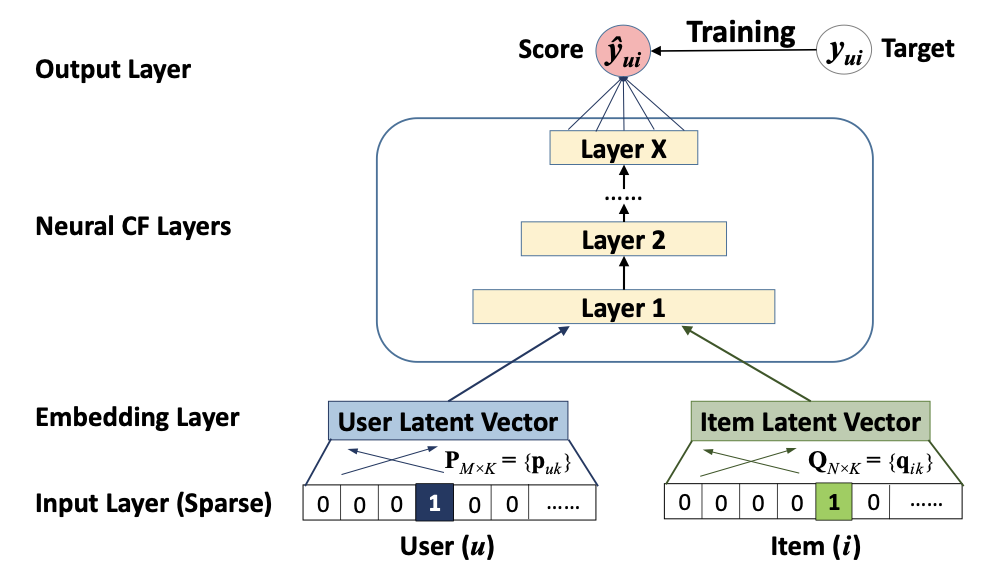

Мы уже видели эту архитектуру в предыдущем занятии, но не стали использовать все ее возможности.

Следующим подходом авторов было добавить GMF к NCF.  
В данном случае GMF – Generalized Matrix Factorization, то есть, помимо нейросети с изображения выше авторы добавляют обычную факторизацию матриц с двум отличиями: на вход подаются те же общие эмбеддинги от NCF и на выходе стоит сигмоида. Затем выход с GMF и с NCF объединяется в финальный слой.

Один из недостатков такой модели - возможность того, что оптимальные эмбеддинги для двух моделей будут отличаться и модель не сможет подобрать оптимальный набор скрытых признаков для описания взаимодействий пользователей.

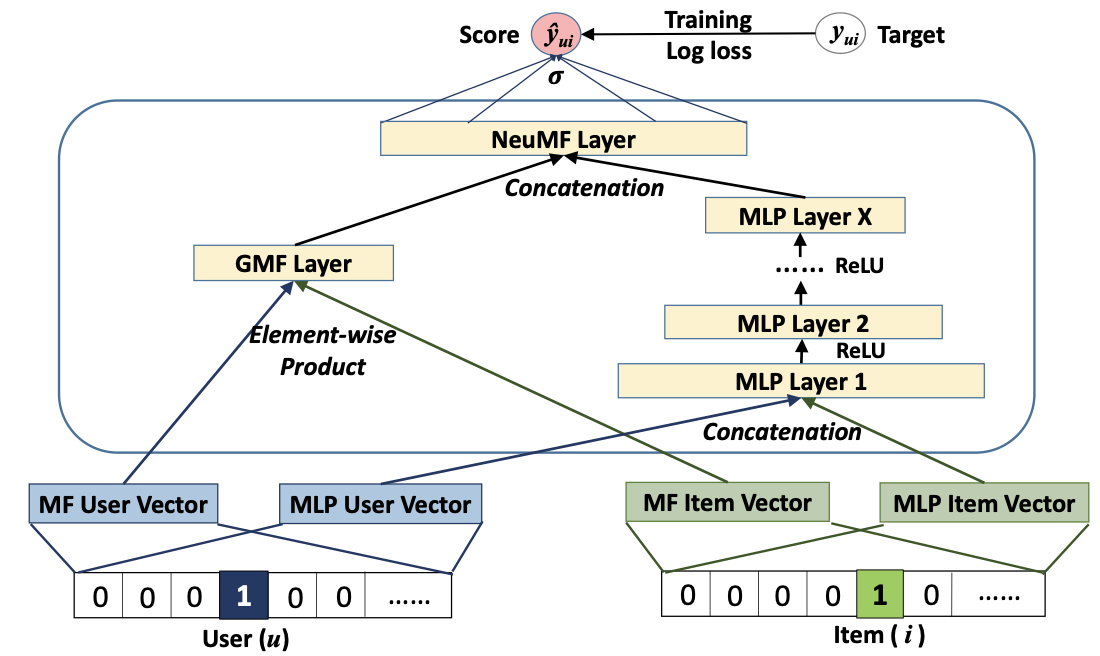

## 2.4. DeepFM

DeepFM похож на предыдущий подход, но слой с эмбеддингами является общим для последующих моделей и не является полносвязным в обычном смысле нейронных сетей: модель содержит несколько эмбеддингов одинакового размера (независимо от длины входных векторов) и эмбеддинги независимы друг от друга.

Плюс в том, что:
1. Нет нужды отдельно обучать модель для матричной факторизации, так как она принимает на вход уже готовые эмбеддинги и модель обучается end-to-end
2. Нет нужды в ручном конструировании признаков. Здесь авторы ссылаются на Wide&Deep модель, которая похожа на текущую, но вместо FM части есть набор вручную созданных признаков, которые отражают низкоуровневые взаимодействия.

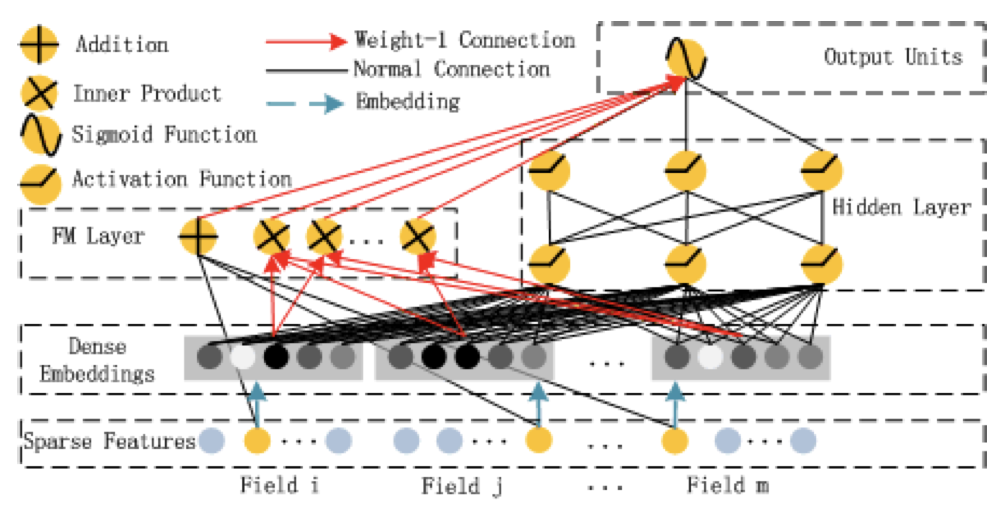

## 2.5. Deep Learning Recommendation Model (DLRM)
Одной из последних моделей на данный момент является DLRM.  
Главное отличие этой модели, например, от DeepFM, является то, что она разделяет continuous и categorical признаки и обрабатывает их отдельно, представляя категориальные признаки в виде эмбеддингов, как в FM. Продолжительные признаки при этом просто проходят сквозь обычную полносвязную модель с таким же размеров выхода, как и у эмбеддингов. 

Затем, модель явно перемножает признаки, чтобы найти взаимодействия второго порядка, и отправляет их в еще одну полносвязную сеть, а затем в сигмоиду, чтобы получить предсказание. 

Последствием такого подхода является то, что авторы не заставляют модель учить взаимодействия порядков выше 2 не нужны:  
`We argue that higher- order interactions beyond second-order found in other networks may not necessarily be worth the additional computational/memory cost.`

При этом, модель достигает отличных результатов, но не требует больших вычислительных затрат и хорошо параллелится.

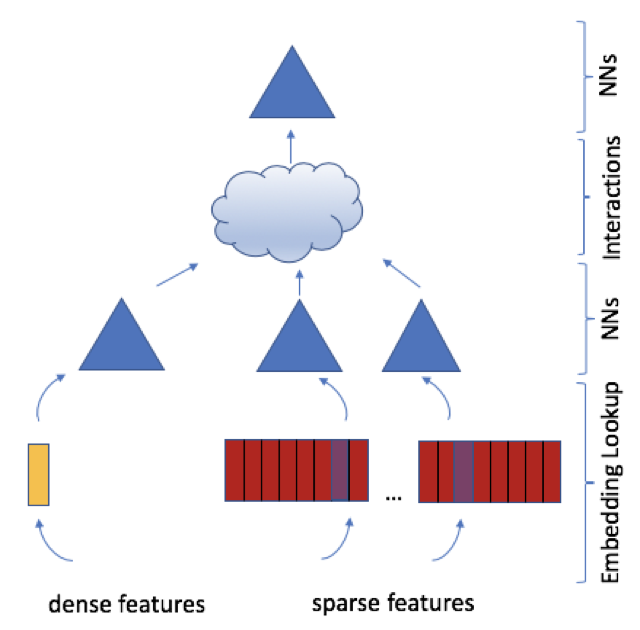

# 3. Дополнительные материалы

## 3.1. SLIM – Sparse LInear Method

SLIM – алгоритм для нахождения рекомендаций, который эффективно работает с разреженными (sparse) матрицами, решая регуляризованную (l1, l2) задачу оптимизации. Написан на C, есть интерфейс на Python.

https://github.com/KarypisLab/SLIM

## 3.2. Context Aware Recommender Systems

Контекстные рекомендательные системы (одно из первых появлений – в этой [статье](https://link.springer.com/chapter/10.1007/978-0-387-85820-3_7)) – рекомендательные системы, которые учитывают текущий контекст. 

Авторы говорят о двух типах контекста:
1. Representational – какие-то параметры контекста известны заранее их их можно посчитать во время обучения модели
2. Interactional – динамические признаки, от которых может зависеть предсказание. Например, время дня или день недели

Затем, авторы предлагают три варианта того, как можно включать контекст в предсказания:


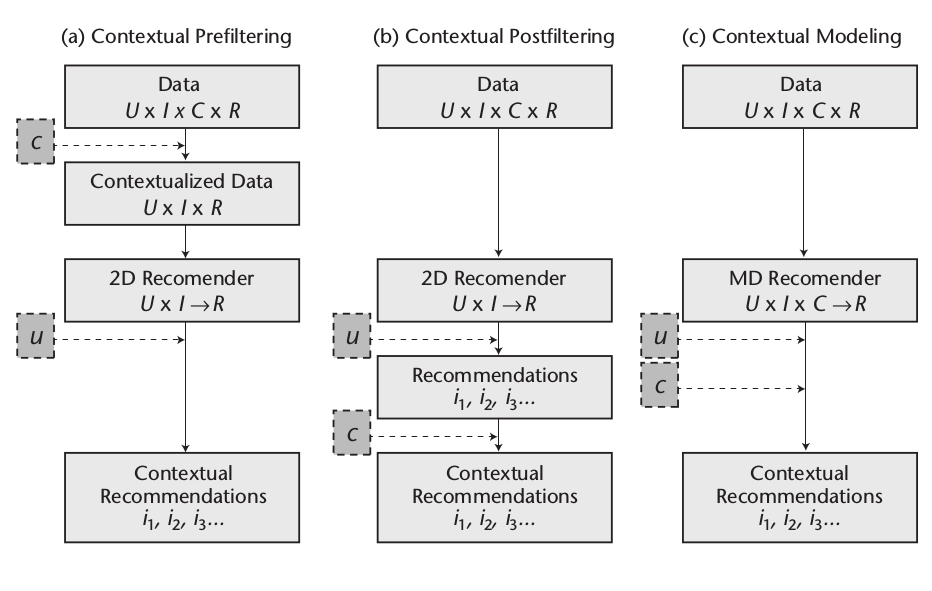

1. Prefiltering: Контекст – это набор данных, который добавляется на этапе сбора данных о пользователях и объектах. Например, можно помещать пользователей, находящихся в разных контекстах, в разные группы и рассматривать отдельно.
2. Postfiltering: Сначала работает обычная рекомендательная система, а затем ее результаты фильтруются или переранжируются в зависимости от набора контекстных правил.
3. Modeling: Контекст используется в самой модели (и это один из частых подходов в гибридных моделях). Например, на входе может быть отдельная модель для рекомендаций и отдельная модель для предсказания контекста. Затем выходы с обеих моделей идут на вход мета-модели для построения финального предсказания.

Пример реализации: https://github.com/yadavgaurav251/Context-Aware-Recommender

## 3.3. GAN-based Matrix Factorization for Recommender Systems 

Генеративные модели набирают популярность в рекомендательных системах. Один из подходов – использование GANs для факторизации матриц, чтобы получить латентные представления признаков пользователей и объектов, которые затем можно использовать в других системах.

Реализация на Python: https://github.com/edervishaj/gan-mf-thesis

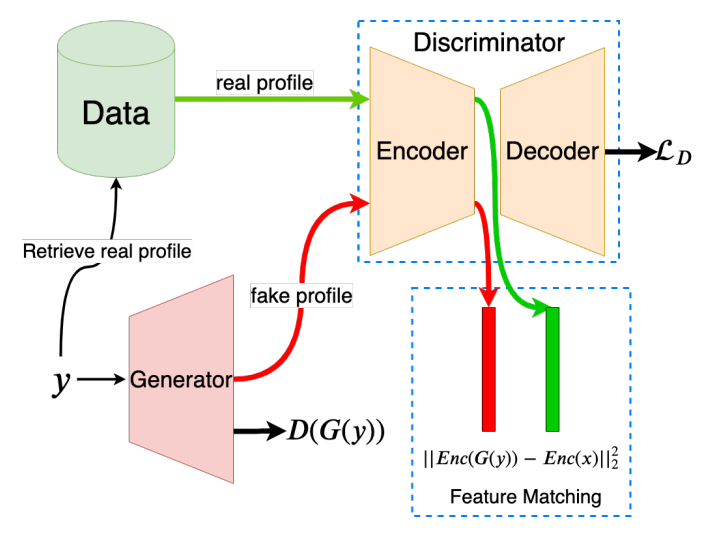

## 3.4. Model-Based Reinforcement Learning with Adversarial Training for Online Recommendation

Обучение с подкреплением также используется в рекомендательных системах. Есть примеры совмещения предыдущего подхода (GAN) с RL для построения рекомендаций.

В данном подходе дискриминатор учится похожим образом и затем используется для оценки действий агента. После обучения GAN начинается построения Policy function для агента – функции, которая будет определять, как действовать в зависимости от входных данных. 

Агент получает входные данные, выбирает один из результатов исходя из Policy, затем получает награду или штраф и обновляет свою Policy. Изначально Policy задается случайным образом, но можно попробовать совместить ее с контекстным подходом из этого же списка.

Реализация на Python (tensorflow): https://github.com/JianGuanTHU/IRecGAN

Есть похожая статья с реализаций на PyTorch: https://github.com/rushhan/Generative-Adversarial-User-Model-for-Reinforcement-Learning-Based-Recommendation-System-Pytorch

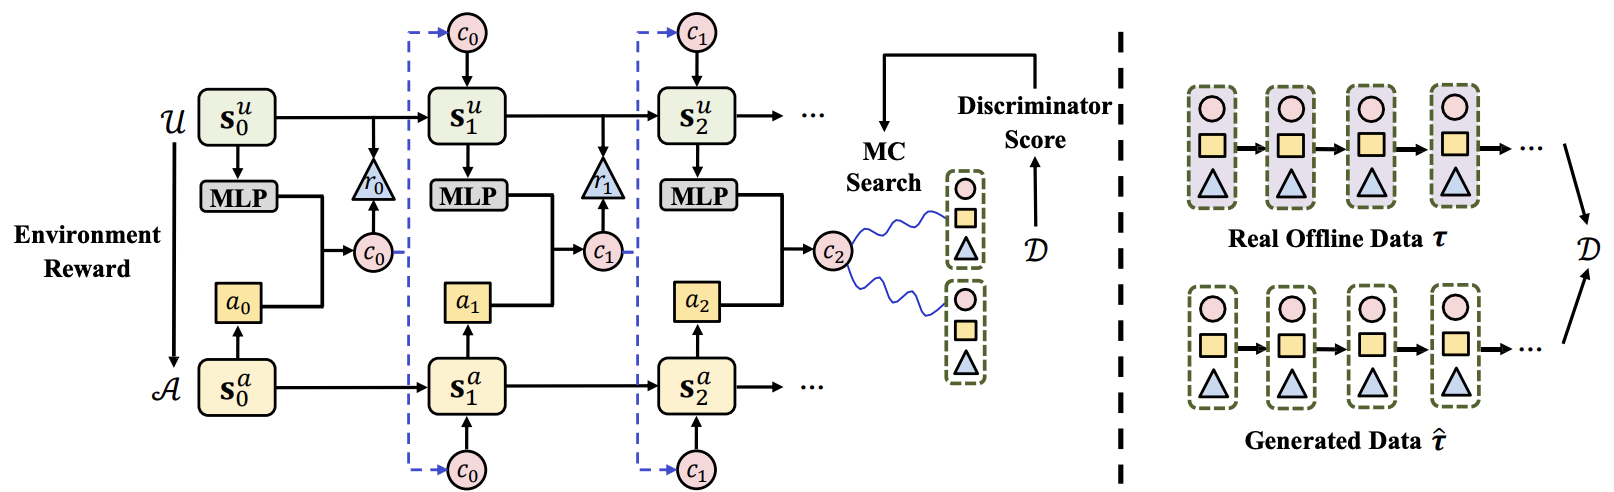

## 3.5. Siamese Neural Networks (SNN)

SNN используются во многих областях, где нужно построить рекомендации. Более того, SNN используются не только для рекомендаций, но и, например, для определения подлинности подписей, написанных от руки.

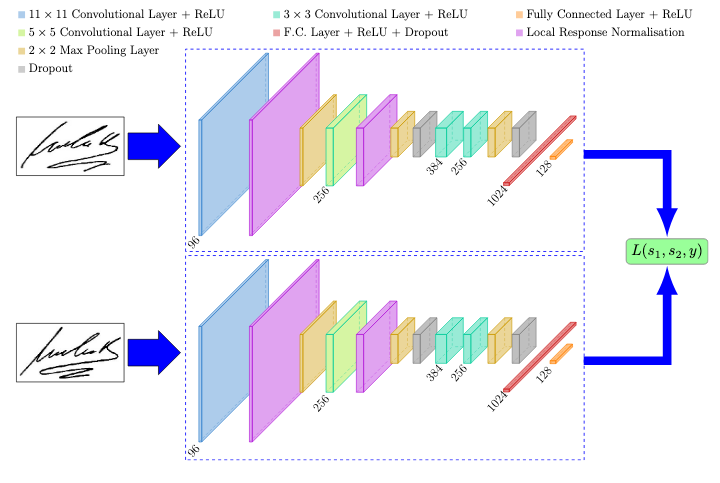

Суть в том, что сиамские сети имеют в своей архитектуре несколько параллельных идентичных сетей, которые обучаются, чтобы построить скрытое представление классов, на которых модель обучается.

На этапе предсказания можно делать одну из следующих вещей:
* Использовать одну ветку модели, чтобы получить представление входного объекта. Затем это представление можно использовать в других рекомендательных моделях 
  * Также, выходное представление можно сравнить с уже существующими средними представлениями классов и сразу дать рекомендацию о похожести на тот или иной класс
* Использовать две (или более) ветки модели и получить score, который будет говорить о том, насколько близки входные примеры. Это можно затем использовать для ранжирования выходных результатов